# Reproducing the Experiment in "Prediction of Pedestrian Speed with Artificial Neural Networks" by Tordeux et al.

In [ ]:
# Enable these if automatic reloading of modules is wanted

# Load extension for automatic reload of modules
%load_ext autoreload
# Enable autoreload for all modules
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

import torch
from torch.utils.data import DataLoader
import logging
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import tensorboard
from sklearn.preprocessing import MinMaxScaler

import preprocessing
import plotting
import pedestrian_dataset
import pedestrian_net
from weidmann_method import *

## Tensorboard

Extension for visualizing the training results.
Should only be loaded once, otherwise there is probably an error message.

To start, run `tensorboard --logdir=dir --port 6006` in a terminal or run the following cell.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6009

## Logging

I used Logging to print messages.
If more messages are welcome, use the logging level `logging.INFO` or even `logging.DEBUG`.
If not, use `logging.WARNING`.

In [ ]:
# Set Logging Level
logger_format = '%(levelname)s - %(funcName)s \t%(message)s'
logger_level = logging.WARNING
logging.basicConfig(level=logger_level, format=logger_format)

In [ ]:
# Set a torch seed
torch.manual_seed(1234)

## Preprocessing and Loading the Dataset

The different files of data in the format
(`PedID FrameID X Y Z`)
are loaded and converted into the following dictionary format:

`distances` | `speeds`
-|-
Input of our neural network. Array of size $2k+1$ containing the median speed of the $k$ nearest neighbors as the first element and the relative $x$- and $y$-positions of the $k$ nearest neighbors in the following pattern afterwards: $x_1$, $y_1$, $x_2$, $y_2$, ... | Truth value for our neural network. The speed that the pedestrian had in that frame.

To load a list of files, the method `pedestrian_dataset.create_dataset()` is used.
As its first parameter it either takes a list of data files that it should load
or a `pedestrian_dataset.PedestrianDataType` value,
which can be either `BOTTLENECK`, which loads all bottleneck files,
`CORRIDOR`, which loads all corridor files,
or `ALL`, which loads all files.

In [ ]:
# Creating datasets with only the smallest corridor scenario with 30 participants
c_015_path = "./Data/Corridor_Data/ug-180-030.txt"
# Note: even when only loading one dataset, it has to be given in a list
c_015_train_val_datasets, c_015_test_dataset = pedestrian_dataset.create_dataset([c_015_path])

# Print the first item from the first train/val dataset part
print(c_015_train_val_datasets[0][0])

In [ ]:
batch_size = 16

# Create a PyTorch dataloader with the dataset

# TODO: I don't know how to do cross validation, so we combine the first 4 train/val datasets
#   to build the train dataset and use the last train/val dataset as the val dataset
#   Maybe we just have to do this everytime (and switch it up)? Could be, but not sure
c_015_temp_train_dataset = torch.utils.data.ConcatDataset(c_015_train_val_datasets[:4])
c_015_temp_val_dataset = c_015_train_val_datasets[4]

c_015_train_loader = DataLoader(c_015_temp_train_dataset, batch_size=batch_size, drop_last=True)
c_015_val_loader = DataLoader(c_015_temp_train_dataset, batch_size=batch_size, drop_last=False)

c_015_test_loader = DataLoader(c_015_test_dataset, batch_size=batch_size, drop_last=False)

# # Print the first value given by the train loader
# for item in c_015_train_loader:
#     print(item)
#     break  # break after printing the first item

In [ ]:
# Creating datasets with all scenarios loaded
all_train_val_datasets, all_test_dataset = pedestrian_dataset.create_dataset(
    pedestrian_dataset.PedestrianDataType.ALL
)

# Print the first item from the first train/val dataset part
print(all_train_val_datasets[0][0])

In [ ]:
batch_size = 10000

# Create a PyTorch dataloader with the dataset

# TODO: I don't know how to do cross validation, so we combine the first 4 train/val datasets
#   to build the train dataset and use the last train/val dataset as the val dataset
#   Maybe we just have to do this everytime (and switch it up)? Could be, but not sure
all_temp_train_dataset = torch.utils.data.ConcatDataset(all_train_val_datasets[:4])
all_temp_val_dataset = all_train_val_datasets[4]

all_train_loader = DataLoader(all_temp_train_dataset, batch_size=batch_size, drop_last=True)
all_val_loader = DataLoader(all_temp_train_dataset, batch_size=batch_size, drop_last=False)

all_test_loader = DataLoader(all_test_dataset, batch_size=batch_size, drop_last=False)

# # Currently Disabled because for batch_size=16 this get's large
# # Print the first value given by the train loader
# for item in all_train_loader:
#     print(item)
#     break  # break after printing the first item

In [ ]:
# Create normalized DataLoaders

normalized_train_loader = DataLoader(preprocessing.normalize_data(all_temp_train_dataset), batch_size=batch_size, drop_last=True)
normalized_val_loader = DataLoader(preprocessing.normalize_data(all_temp_val_dataset), batch_size=batch_size, drop_last=True)
normalized_test_loader = DataLoader(preprocessing.normalize_data(all_test_dataset), batch_size=batch_size, drop_last=False)

In [ ]:
print(normalized_train_loader)

## Implementing and Training the Model

Now we need to define our model.

@Parim:
I got quite a lot of work done on the model, but there are still TODOs.
I probably won't be able to work more on the practicum this week, but I think everything should be documented well enough to be extended by you.
(I'm using PyTorch Lightning now, which you'll probably remember from I2DL, and the Neural Network is in `pedestrian_net.py`.)

### Model 1 - Weidmann Method Fundamental Diagram

In [3]:
bottleneck_train_val_dataset, bottleneck_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.BOTTLENECK)
corridor_train_val_dataset, corridor_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.CORRIDOR)
all_train_val_dataset, all_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.ALL)

Optimized parameters:  [0.99459926 0.52054795 1.02308064]


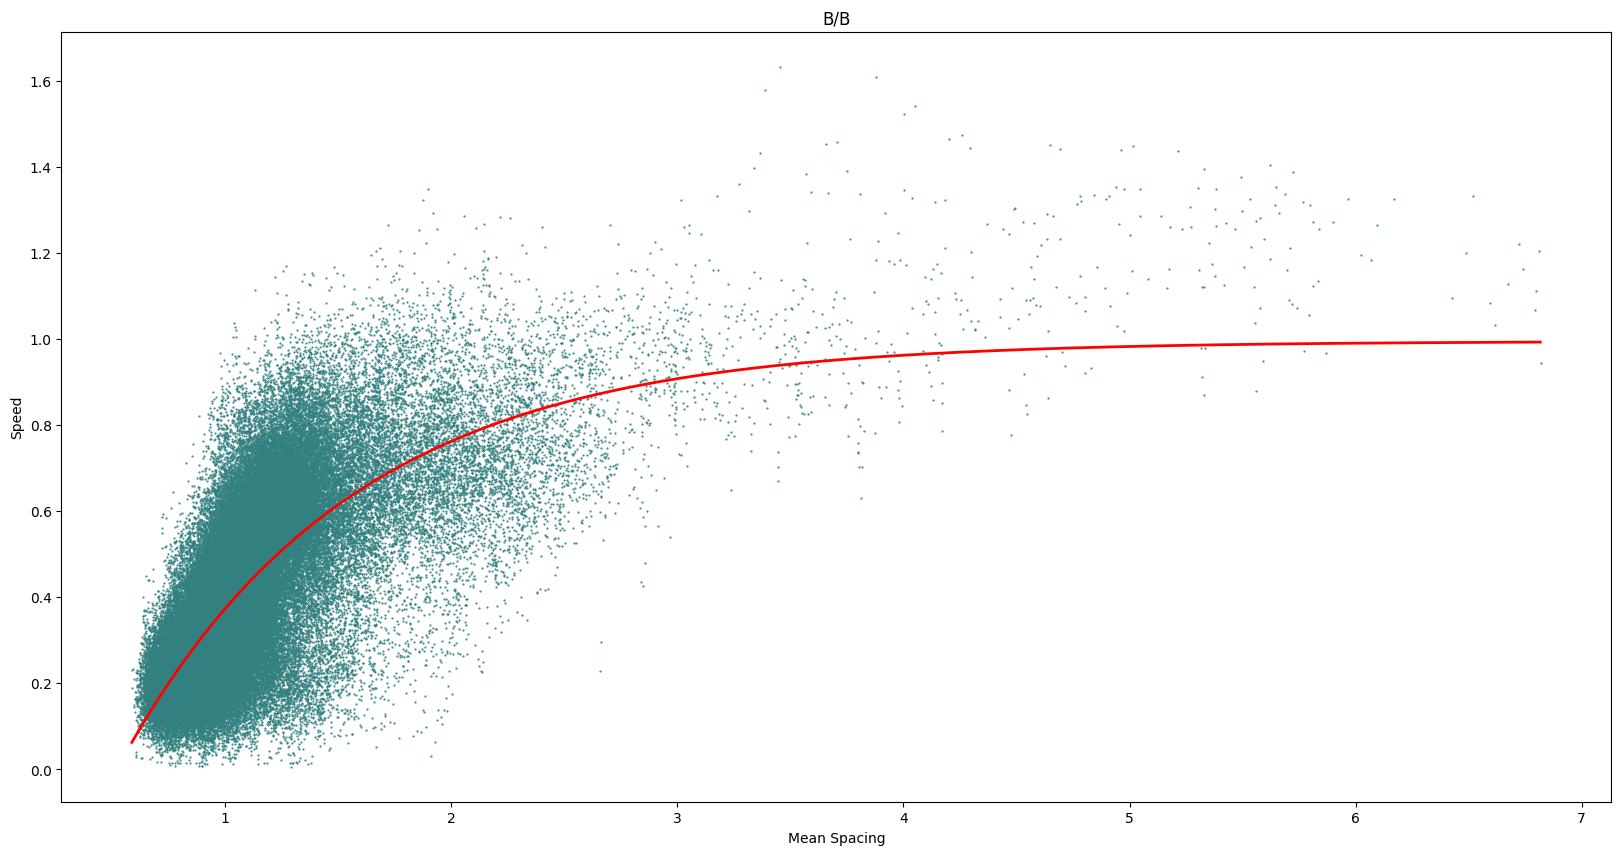

Optimized parameters:  [0.75831408 0.62022338 1.51903569]


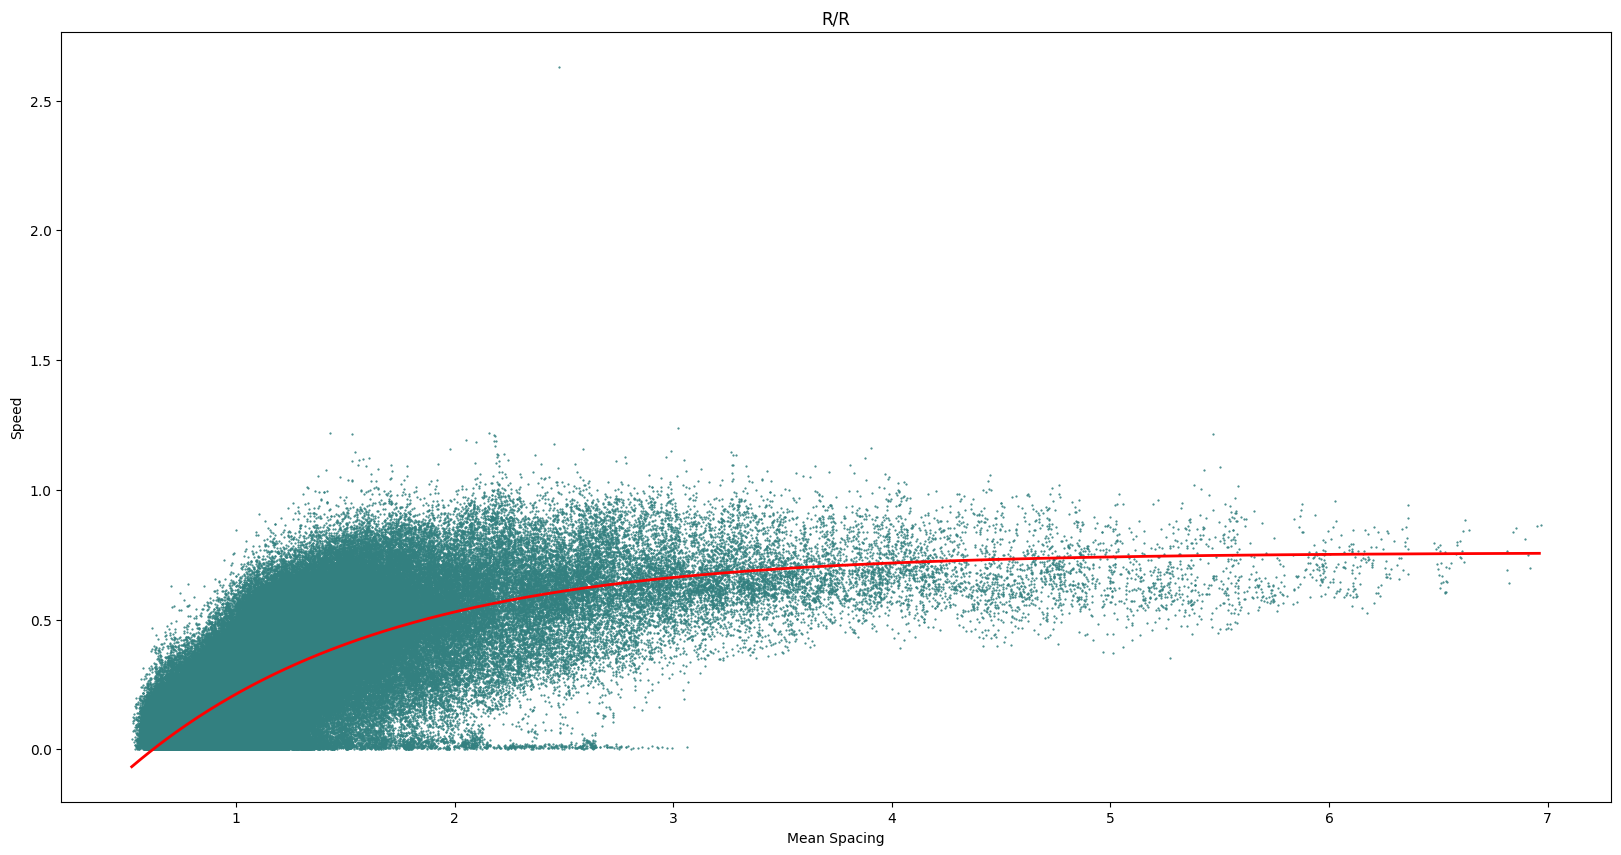

Optimized parameters:  [0.99459926 0.52054795 1.02308064]


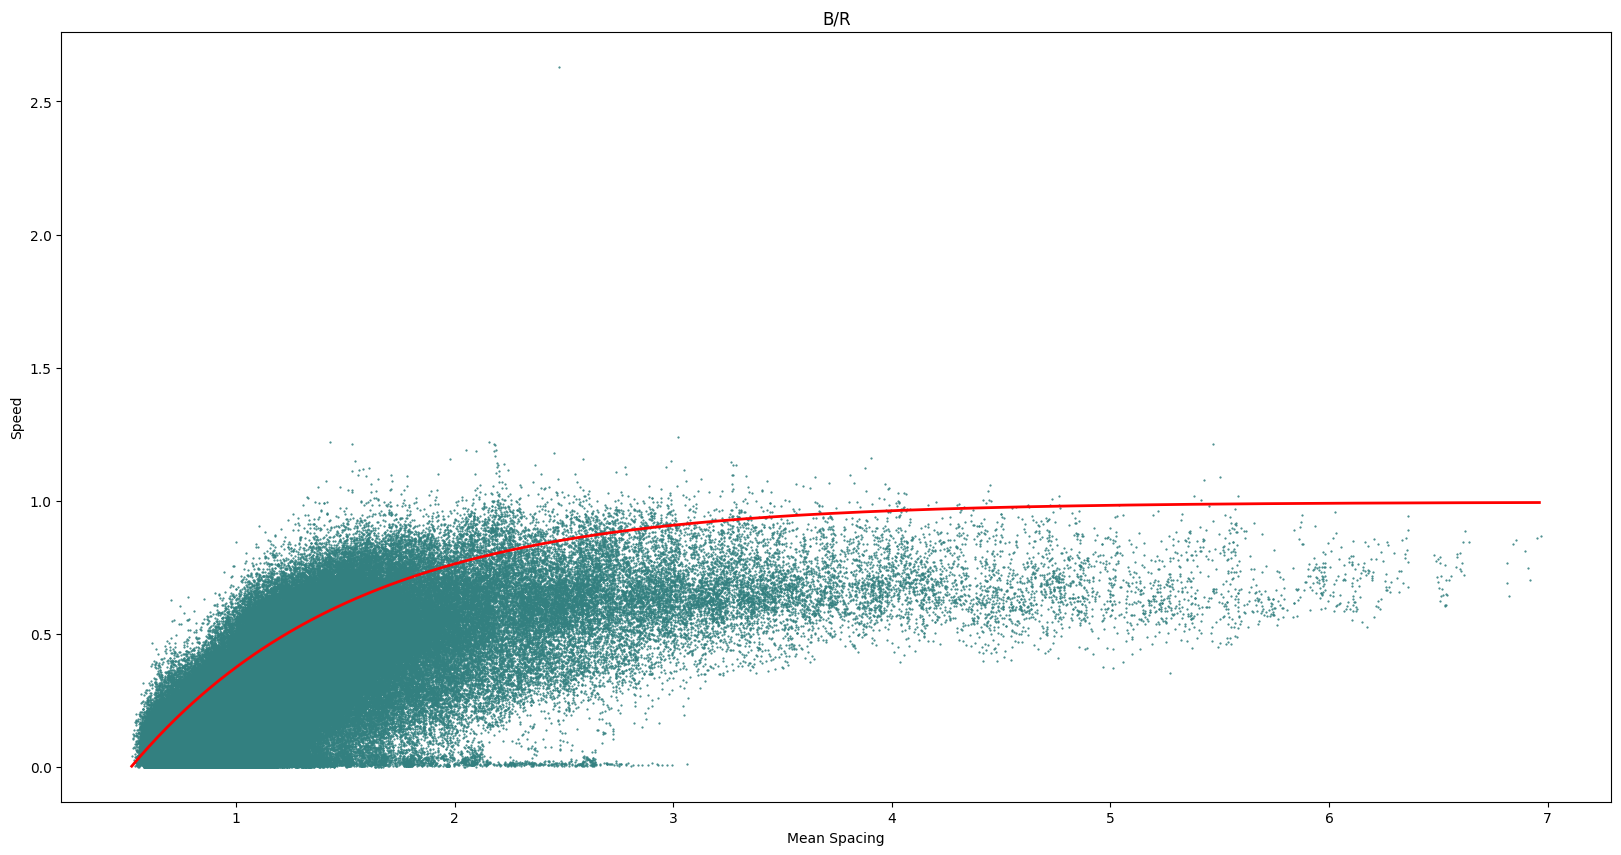

Optimized parameters:  [0.75831408 0.62022338 1.51903569]


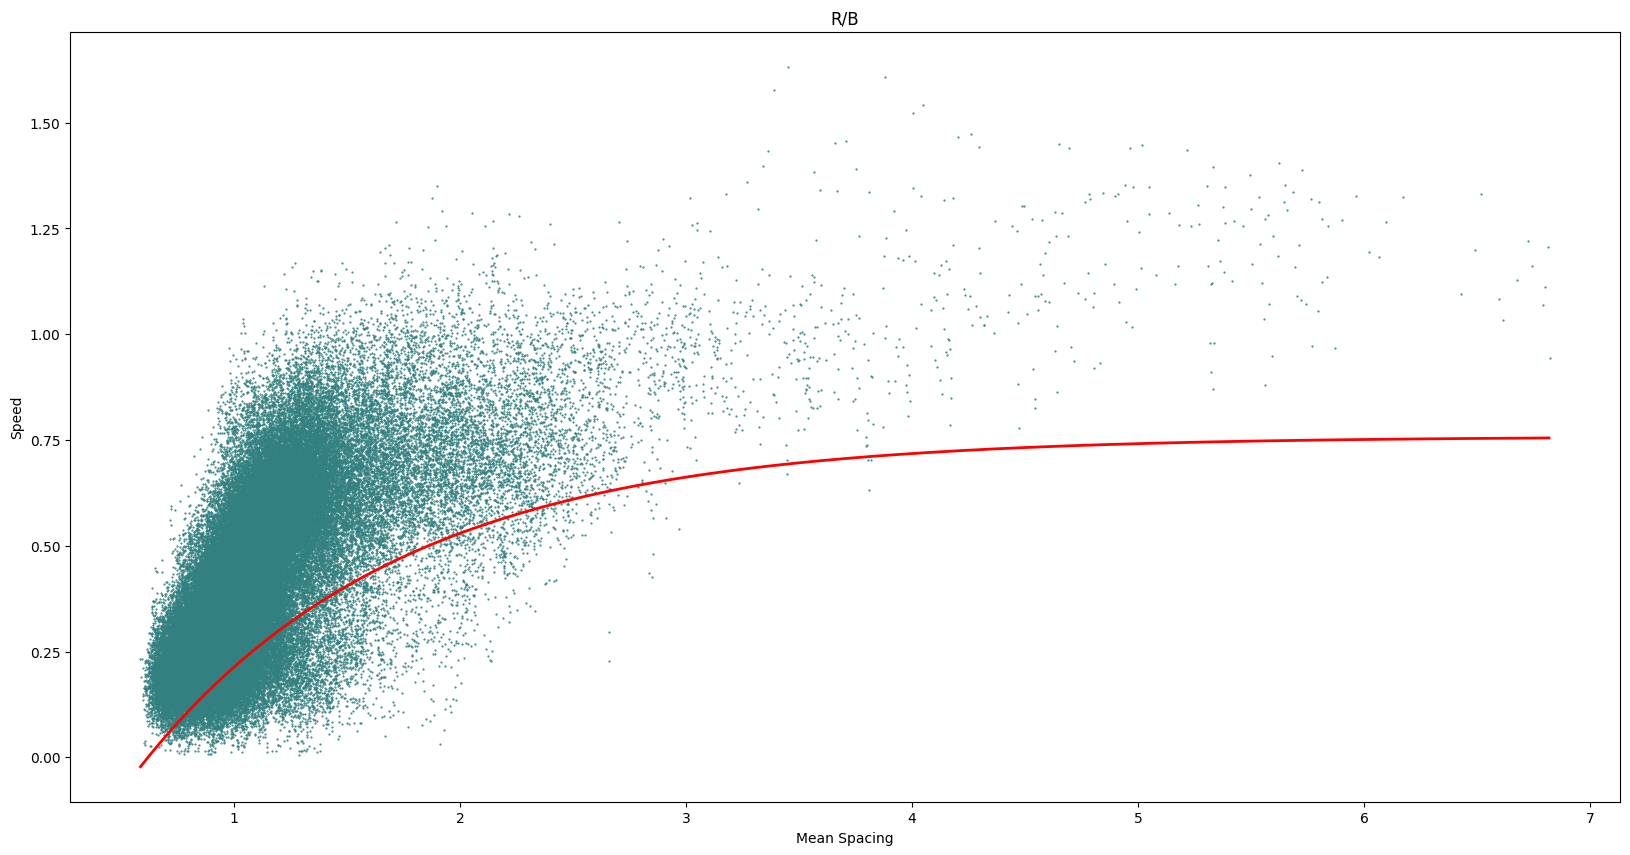

Optimized parameters:  [0.74556797 0.5997466  1.28412516]


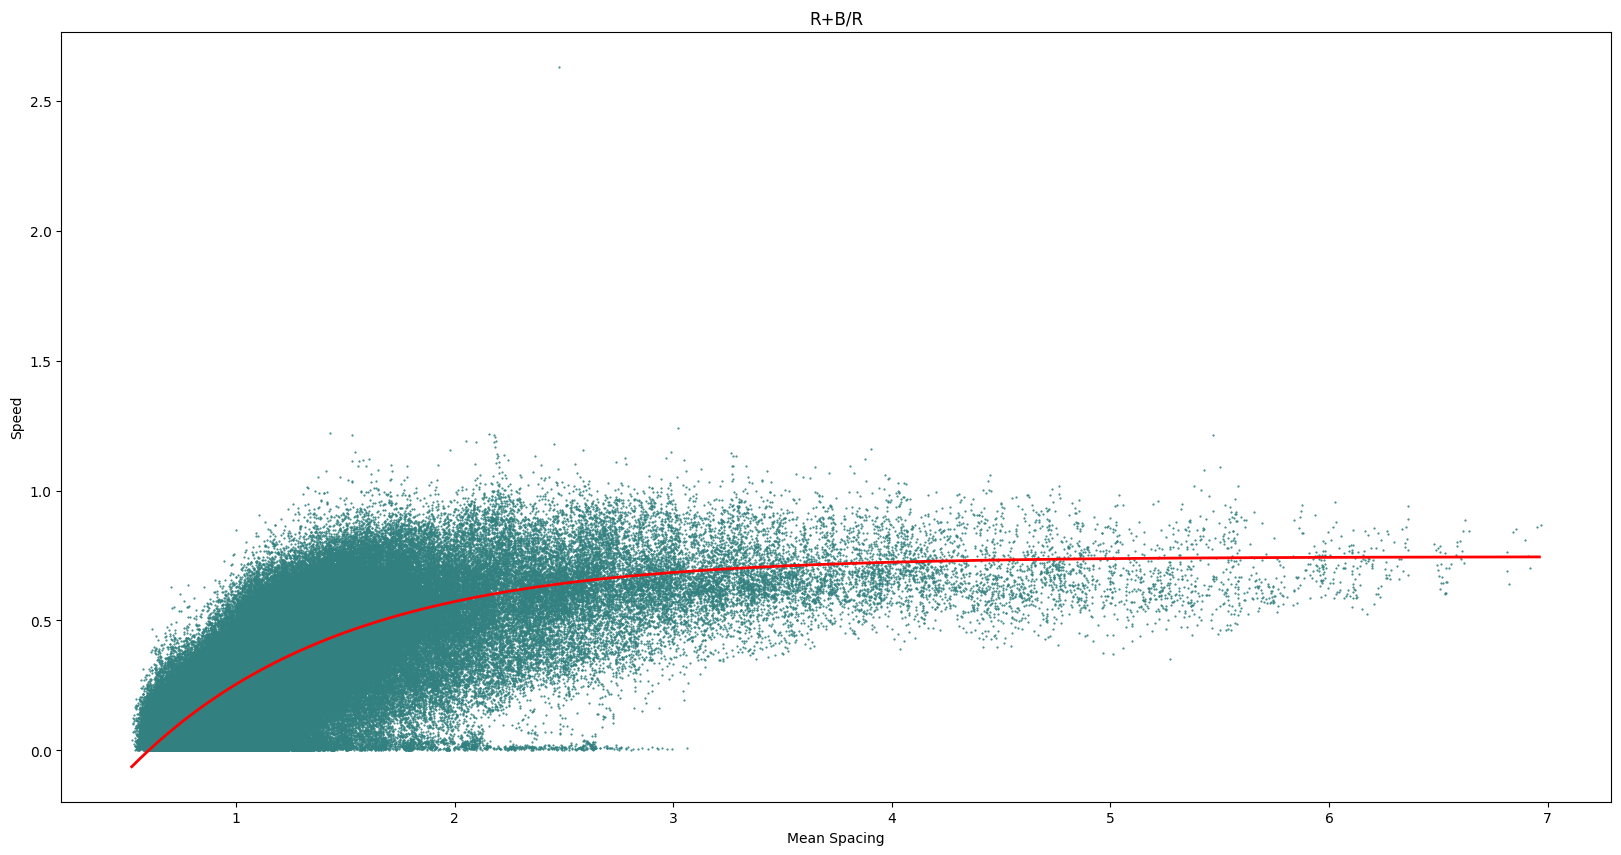

Optimized parameters:  [0.74556797 0.5997466  1.28412516]


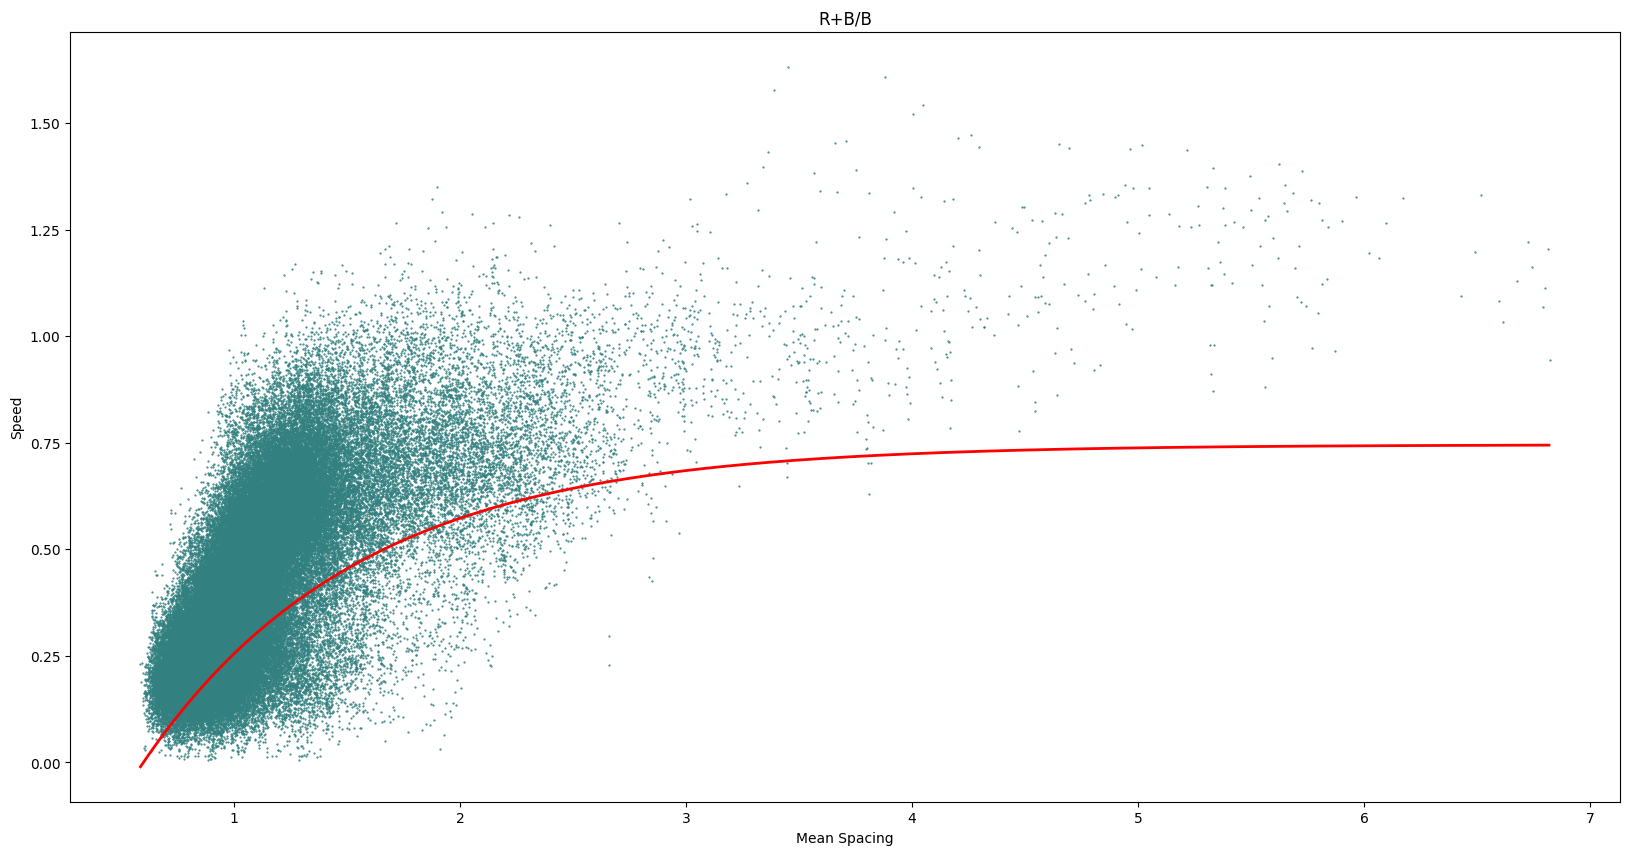

Optimized parameters:  [0.74556797 0.5997466  1.28412516]


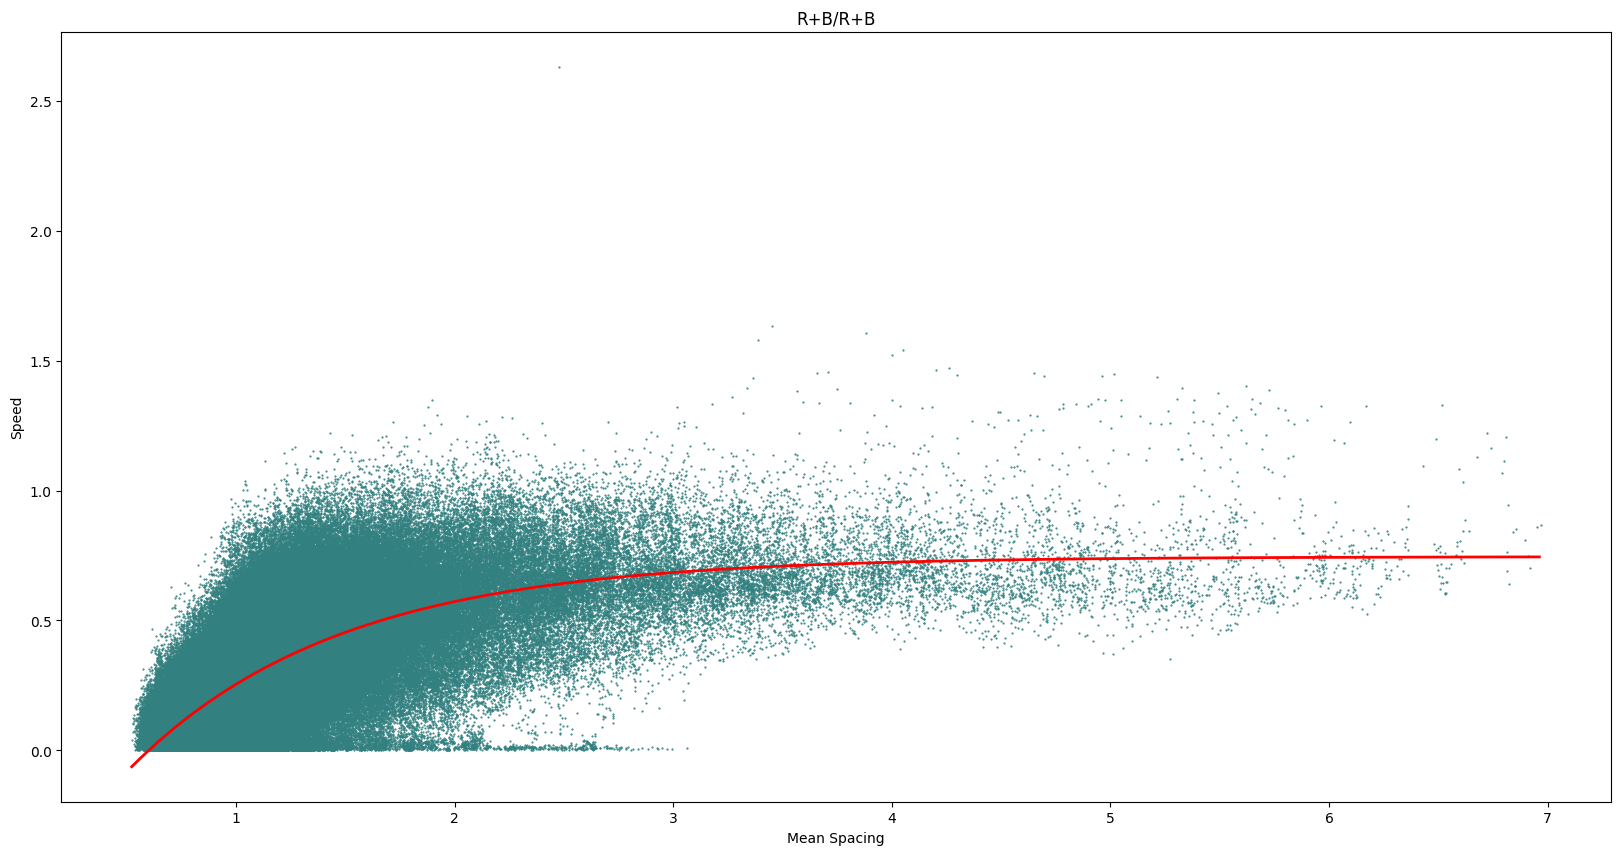

In [14]:
load_dataset = {'B/B': [bottleneck_train_val_dataset, bottleneck_test_dataset],
                'R/R': [corridor_train_val_dataset, corridor_test_dataset ], 
                'B/R': [bottleneck_train_val_dataset, corridor_test_dataset],
                'R/B': [corridor_train_val_dataset, bottleneck_test_dataset],
                'R+B/R': [all_train_val_dataset, corridor_test_dataset], 
                'R+B/B': [all_train_val_dataset, bottleneck_test_dataset],
                'R+B/R+B': [all_train_val_dataset, all_test_dataset]}
initial_guess = [0.5, 0.5, 0.5]

mse_dic = {}
for i in load_dataset:
    # Prepare the data for the Weidmann method
    train_weidmann_x, train_weidmann_y, test_weidmann_x, test_weidmann_y = preprocessing.prepare_weidmann_data(load_dataset[i][0], load_dataset[i][1])

    # Use the Weidmann method to fit the data and get the optimized parameters and the mean squared error (mse)
    optimized_parameters, mse, y_fit = use_weidmann_method(train_weidmann_x, train_weidmann_y, test_weidmann_x, test_weidmann_y, initial_guess=initial_guess)
    print("Optimized parameters: ", optimized_parameters)
    # Plot the results
    curve_model = np.arange(min(test_weidmann_x), max(test_weidmann_x), 0.01)
    curve_pred = weidmann_equation(curve_model, *optimized_parameters)
    plot_fd_curve(test_weidmann_x, test_weidmann_y, curve_model, curve_pred, title=i)
    mse_dic[i] = mse

In [13]:
print(mse_dic)

{'B/B': 0.020054688396093857, 'R/R': 0.019752376508118525, 'B/R': 0.04880660061056964, 'R/B': 0.048283424634619536, 'R+B/R': 0.02136058722159929, 'R+B/B': 0.03634303387688736, 'R+B/R+B': 0.024880665027348804}


In [ ]:
train_weidmann_x, train_weidmann_y, test_weidmann_x, test_weidmann_y = preprocessing.prepare_weidmann_data(bottleneck_train_val_dataset , bottleneck_test_dataset)

dataset_mean_spacing = train_weidmann_x + test_weidmann_x
dataset_speed = train_weidmann_y + test_weidmann_y

plotting.plot_histogram(dataset_mean_spacing, xlabel='Mean spacing',  title='Bottleneck Mean Spacing Histogram')
plotting.plot_histogram(dataset_speed, xlabel='Speed',  title='Bottleneck Speed Histogram')


{'B/B': 0.02005468739833246, 'R/R': 0.019752375643579286, 'B/R': 0.04880653652427651, 'R/B': 0.048283510767569156, 'R+B/R': 0.02136058870671394, 'R+B/B': 0.03634302896394584, 'R+B/R+B': 0.02488066500926068}


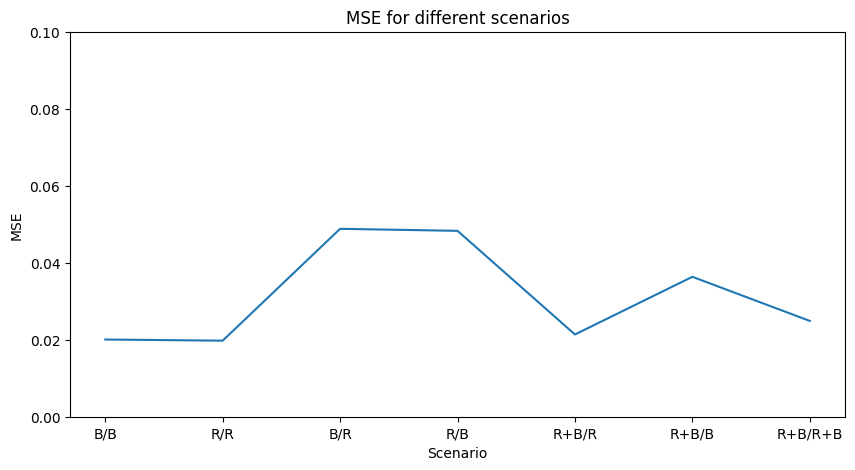

In [16]:
print(mse_dic)

# Plot mse_dic as a line plot
plt.figure(figsize=(10, 5))
plt.ylim(ymin=0, ymax=0.1)
plt.plot(list(mse_dic.keys()), list(mse_dic.values()))
plt.title('MSE for different scenarios')
plt.xlabel('Scenario')
plt.ylabel('MSE')
plt.show()

### Model 2 - Artificial Neural Networks

In [ ]:
checkpoint_name = "./.name/checkpoints/2023-07-05--dataAll-ep100-it001.ckpt"

max_epochs = 50
k = 10
hidden_size = 3
learning_rate = 1e-3
optimizer = torch.optim.Adam

In [ ]:
# Use GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available.")
else:
    device = torch.device('cpu')
    print("CPU will be used.")

In [ ]:
# Choose our dataloaders
# train_loader = all_train_loader
# val_loader   = all_val_loader
# test_loader  = all_test_loader

train_loader = normalized_train_loader
val_loader = normalized_val_loader
test_loader = normalized_test_loader

In [ ]:
# define an early stopping callback
early_stop_callback = EarlyStopping(monitor="val_loss", mode='min', patience=20)

In [ ]:
# Define our model
model = pedestrian_net.PedestrianNet(k=k,
                                     hidden_size=hidden_size,
                                     learning_rate=learning_rate,
                                     optimizer=optimizer
                                     )
model.to(device)

In [ ]:
trainer = pl.Trainer(
    max_epochs=max_epochs,
    devices='auto',
    accelerator='gpu',
    callbacks=[early_stop_callback],
    log_every_n_steps=1,
    enable_checkpointing=True
)

In [ ]:
trainer.fit(model, train_loader, val_loader)

In [ ]:
print("Done")

In [ ]:
trainer.save_checkpoint(checkpoint_name)

## Testing the Model

**After** training and tuning the model, we can test the model.

In [ ]:
trainer.test(model, dataloaders=test_loader)

# TODO

A list of some things that are still to do.
Not a complete list.

- [x] Implement Preprocessing
- [x] Implement Data Preparation
- [x] Implement Model basic structure
- [x] Set up basic training for model
- [ ] Implement cross validation
- [ ] Implement hyper parameter tuning
- [ ] ...
- [ ]

In [ ]:
model(torch.tensor(all_temp_train_dataset[0]['distances']))

In [ ]:
all_temp_train_dataset[0]['speed']